# **Matrix Factorization Algorithm**

Matrix factorization is a collaborative filtering method used to predict missing entries in the user-item interaction matrix by decomposing it into two low-dimensional matrices:  Q (user embeddings) and P (item embeddings).

##### Initialize Matrices
- Randomly initialize  Q  and  P 
- Alternatively, use metadata embeddings to initialize these matrices.

---

##### Optimize for Loss Function
The goal is to minimize the squared error with regularization:

$$
L = \sum_{(i,j) \in R} \left( R_{ij} - Q_i \cdot P_j^\top \right)^2 + \lambda \left( \|Q_{i}\|^2 + \|P_{j}\|^2 \right)
$$

Where:
- R : The user-item interaction matrix.
- $R_{ij}$: Observed rating for user i and item j.
- $Q_i$ : Latent vector for user i.
- $P_j$ : Latent vector for item j.
- lambda : Regularization parameter to prevent overfitting.
- $|Q|^2$
---

##### Iterative Updates
- Update Q and P alternately to minimize the loss function L.
- Common optimization techniques include:
  
  
  - **Alternating Least Squares (ALS):**
  
    - Fix P and solve for Q, then fix Q and solve for P.
  
  - **Stochastic Gradient Descent (SGD):**
  
    - Update Q and P by iteratively taking gradient steps on L.

---

##### Output
- Q : Captures user preferences in a latent space.
- P : Captures item characteristics in the same latent space.

The predicted rating for user  i and item j is given by:

$$
\hat{R}_{ij} = Q_i \cdot P_j^\top
$$


In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [1]:

# Example of the 'ratings' DataFrame
# 
df_recommendation = pd.read_csv("base de donnée_20_20.csv")
ratings = df_recommendation[['user', 'id', 'rating']]

# Create user-item interaction matrix
user_ids = ratings['user'].unique()
item_ids = ratings['id'].unique()
user_id_map = {id: idx for idx, id in enumerate(user_ids)}
item_id_map = {id: idx for idx, id in enumerate(item_ids)}

ratings['user_idx'] = ratings['user'].map(user_id_map)
ratings['item_idx'] = ratings['id'].map(item_id_map)

# Train-Test Split using Leave-One-Out (for each user)
train_data, test_data = [], []

for user in ratings['user_idx'].unique():
    user_data = ratings[ratings['user_idx'] == user]
    if len(user_data) > 1:
        # Leave one out: use all but one interaction for training
        train_data.append(user_data.iloc[:-1])
        test_data.append(user_data.iloc[-1:])  # Last rating is used for testing

train_data = pd.concat(train_data, axis=0)
test_data = pd.concat(test_data, axis=0)

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")


Training data size: 37519
Testing data size: 4875


##### Loss function $\mathbf{L}$ :

$$
L = \sum_{(i,j) \in R} \left( R_{ij} - Q_i \cdot P_j^\top \right)^2 + \lambda \left( \|Q_{i}\|^2 + \|P_{j}\|^2 \right)
$$

##### Dérivée par rapport à $\mathbf{p}_u$ :

$$

\frac{\partial L}{\partial \mathbf{p}_u} = -2 (r_{ui} - \mathbf{q}_i^\top \mathbf{p}_u) \mathbf{q}_i + 2\lambda \mathbf{p}_u
$$


##### Dérivée par rapport à $\mathbf{q}_i$ :

$$

\frac{\partial L}{\partial \mathbf{q}_i} = -2 (r_{ui} - \mathbf{q}_i^\top \mathbf{p}_u) \mathbf{p}_u + 2\lambda \mathbf{q}_i
$$


##### **1rst Training  with fixed regularization term on latent vectors** : 
##### Optimizer : Gradient descent algo

In [4]:
train_data

,user_idx,item_idx,rating
0,0,0,5.0
1,0,1,5.0
2,0,2,5.0
3,0,3,5.0
4,0,4,3.0
...,...,...,...
42620,5106,132,1.0
42621,5106,403,5.0
42622,5106,513,4.0
42623,5106,209,3.0


In [64]:
test_data

,user,id,rating,user_idx,item_idx
7,AE23JYHGEN3D35CHE5OQQYJOW5RA,B09YDBKT7M,5.0,0,7
24,AE23LDQTB7L76AP6E6WPBFVYL5DA,B0BSR996X8,5.0,1,24
32,AE23WLBRYKEC67DM43M6E2MF7GPQ,B0BT9R8MMV,3.0,2,32
60,AE23ZFVUOMPKR57BVSWXV34QLMVA,B0BTC9YJ2W,5.0,3,59
68,AE24I2EU3AJAAKBXF367XSV37U6Q,B0C994NVQK,5.0,4,67
...,...,...,...,...,...
42576,AHZPLXCE5YQMLXFFBSURYHZUGMTA,B0BLLXXT6F,5.0,5102,397
42598,AHZQPH7HHSWLUIQFWEQ54NNKKN6A,B0BTC9YJ2W,1.0,5103,59
42601,AHZT6MVWNF4GG6FISMZMORKZKK4A,B0BQ4HSKC9,5.0,5104,885
42609,AHZXMBKQJTVG2J7P7EB5WCYTOLDQ,B0C67HCGBR,5.0,5105,210


In [20]:
def evaluate_model(test_data, P, Q, verbose = False):
    total_mae = 0
    total_rmse = 0
    num_test_samples = len(test_data)

    for _, row in test_data.iterrows():
        u, i, r_ui = row['user_idx'], row['item_idx'], row['rating']
        prediction = np.dot(P[u], Q[i])
        total_mae += abs(r_ui - prediction)
        total_rmse += (r_ui - prediction) ** 2

    mae = total_mae / num_test_samples
    rmse = np.sqrt(total_rmse / num_test_samples)
    if verbose : 
        print(f"Evaluation Results:\nMAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return mae, rmse


In [68]:

# Hyperparameters
num_factors = 10  # Latent space dimensionality
learning_rate = 0.01
reg_lambda = 0.1
num_epochs = 50

# Initialization of the latent factor matrices
num_users = len(user_ids)
num_items = len(item_ids)
P = np.random.normal(0, 0.1, (num_users, num_factors))  # User latent factors
Q = np.random.normal(0, 0.1, (num_items, num_factors))  # Item latent factors

# Training set
train_data = train_data[['user_idx', 'item_idx', 'rating']]

# User and item frequency dictionaries for regularization
user_frequencies = train_data['user_idx'].value_counts().to_dict()
item_frequencies = train_data['item_idx'].value_counts().to_dict()

# To store the matrices P and Q at different epochs
stored_P = [P]
stored_Q = [Q]

loss_evolution = []
mae_evolution = []
rmse_evolution = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for _, row in train_data.iterrows():
        u, i, r_ui = int(row['user_idx']), int(row['item_idx']), int(row['rating'])
        
        # Frequency-based regularization
        freq_user = user_frequencies[u]
        freq_item = item_frequencies[i]
        
        prediction = np.dot(P[u], Q[i])
        #error = r_ui - prediction 

        # Convert to class 
        predicted_rating = round(prediction) 
        predicted_rating = max(1, min(5, predicted_rating))
        error = r_ui - predicted_rating

        # Regularization terms for user and item
        reg_u = reg_lambda / np.sqrt(freq_user)  # Regularization for user
        reg_i = reg_lambda / np.sqrt(freq_item)  # Regularization for item

        # Update user and item latent factors by gradient descent
        P[u] += learning_rate * (error * Q[i] - reg_u * P[u])
        Q[i] += learning_rate * (error * P[u] - reg_i * Q[i])

        # Accumulate loss (including regularization)
        total_loss += error ** 2 + reg_lambda * (np.linalg.norm(P[u]) ** 2 + np.linalg.norm(Q[i]) ** 2)
    

    if (epoch + 1) % 5 == 0:
        stored_P.append(P.copy())
        stored_Q.append(Q.copy())

    loss_evolution.append(total_loss)
    # Evaluation of model on test set and  MAE & RMSE after each epoch
    mae, rmse = evaluate_model(test_data, P, Q)
    mae_evolution.append(mae)
    rmse_evolution.append(rmse)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f} -- MAE: {mae:.4f} -- RMSE: {rmse:.4f}")



Epoch 1/50, Loss: 497297.1369 -- MAE: 4.5300 -- RMSE: 4.6326
Epoch 2/50, Loss: 497773.2822 -- MAE: 4.5236 -- RMSE: 4.6267
Epoch 3/50, Loss: 499063.7249 -- MAE: 4.4451 -- RMSE: 4.5561
Epoch 4/50, Loss: 486569.6609 -- MAE: 4.1356 -- RMSE: 4.3014
Epoch 5/50, Loss: 426604.8435 -- MAE: 3.6063 -- RMSE: 3.8641
Epoch 6/50, Loss: 315661.0952 -- MAE: 3.0251 -- RMSE: 3.3645
Epoch 7/50, Loss: 209887.6008 -- MAE: 2.5137 -- RMSE: 2.9095
Epoch 8/50, Loss: 145598.2138 -- MAE: 2.1253 -- RMSE: 2.5519
Epoch 9/50, Loss: 112884.0526 -- MAE: 1.8536 -- RMSE: 2.2901
Epoch 10/50, Loss: 96099.6220 -- MAE: 1.6630 -- RMSE: 2.1013
Epoch 11/50, Loss: 87552.1232 -- MAE: 1.5262 -- RMSE: 1.9640
Epoch 12/50, Loss: 82614.5096 -- MAE: 1.4279 -- RMSE: 1.8628
Epoch 13/50, Loss: 79965.9963 -- MAE: 1.3538 -- RMSE: 1.7844
Epoch 14/50, Loss: 77845.0326 -- MAE: 1.2973 -- RMSE: 1.7239
Epoch 15/50, Loss: 76200.9447 -- MAE: 1.2538 -- RMSE: 1.6771
Epoch 16/50, Loss: 74886.9876 -- MAE: 1.2213 -- RMSE: 1.6412
Epoch 17/50, Loss: 74012

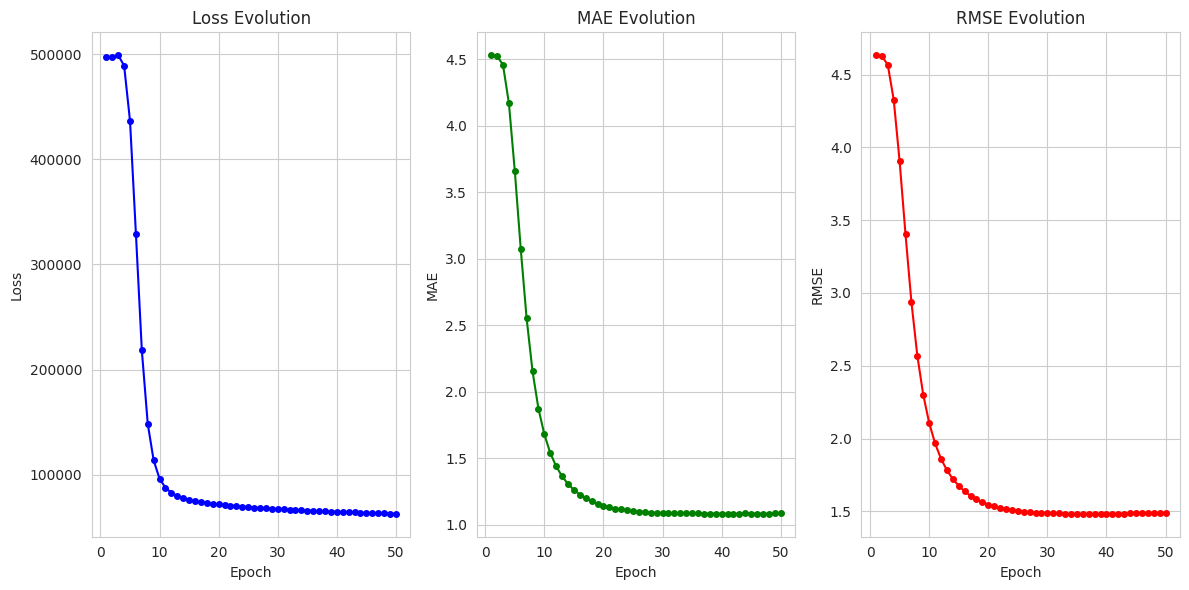

In [61]:
# Plotting Loss, MAE, and RMSE over epochs
plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), loss_evolution, marker='o', color='b', label="Loss",markersize=4)
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plotting MAE
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), mae_evolution, marker='o', color='g', label="MAE",markersize=4)
plt.title('MAE Evolution')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

# Plotting RMSE
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), rmse_evolution, marker='o', color='r', label="RMSE",markersize=4)
plt.title('RMSE Evolution')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.grid(True)


plt.tight_layout()
plt.show()

### **Evaluation : (test set)**

In [62]:
# After training the model, evaluation using test_data
mae_evaluate, rmse_evaluate = evaluate_model(test_data, P, Q, verbose = True)

Evaluation Results:
MAE: 1.0849, RMSE: 1.4874


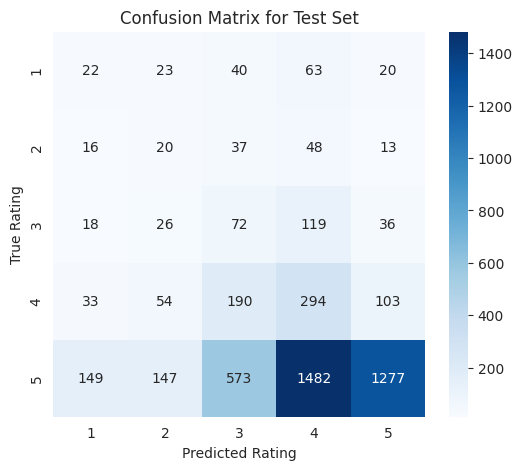

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def prediction_rating ( user_id , item_id ,P , Q ,verbose = True) :
    user_idx = user_id_map[user_id] # nous permer d'avoir l'indice i 
    item_idx = item_id_map[item_id] # nous permet d'avoir l'indice j de la formule

    # If no convertion 
    # predicted_rating = np.dot(P[user_idx], Q[item_idx])
    
    
    # If integer between 1 and 5 convertion
    predicted_rating = np.dot(P[user_idx], Q[item_idx])
    predicted_rating = round(predicted_rating) 
    predicted_rating = max(1, min(5, predicted_rating))


    if verbose : 
        print(f"Predicted Rating for user-item pair: {predicted_rating:.2f}")

    return predicted_rating


# Prédictions sur l'ensemble de test
y_true = []  
y_pred = []  

for _, row in test_data.iterrows():
    user_id = row['user']
    item_id = row['id']
    true_rating = row['rating']
    
    pred_rating = prediction_rating(user_id, item_id, P, Q, verbose = False)
    
    y_true.append(true_rating)
    y_pred.append(pred_rating)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title("Confusion Matrix for Test Set")
plt.xlabel("Predicted Rating")
plt.ylabel("True Rating")
plt.show()


### **Prediction  distibution :** 

In [41]:

# Example 1 : 
user_id = "AE2BETZH5DRTVRVCBYP7PA4NDBPA"
item_id = "B07ZWHY5TD"

pred = prediction_rating( user_id , item_id )
print("The true rating is  : ")
ratings.query(f'user == "{user_id}" and id == "{item_id}"')

Predicted Rating for user-item pair: 2.00
The true rating is  : 


,user,id,rating,user_idx,item_idx
104,AE2BETZH5DRTVRVCBYP7PA4NDBPA,B07ZWHY5TD,2.0,10,99


In [42]:
# Example 2 : 
user_id = "AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ"
item_id = "B095XZJ99J"
pred = prediction_rating( user_id , item_id )
print("The true rating is  : ")
ratings.query(f'user == "{user_id}" and id == "{item_id}"')

Predicted Rating for user-item pair: 5.00
The true rating is  : 


,user,id,rating,user_idx,item_idx
42621,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B095XZJ99J,5.0,5106,403


<Axes: ylabel='Count'>

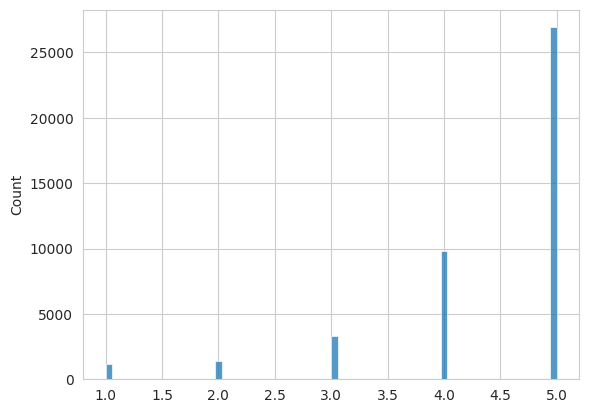

In [46]:

ratings_list = []
for _, row in ratings.iterrows() : 
    user_id = row['user']
    item_id =  row['id']
    pred = prediction_rating( user_id , item_id , verbose = False)
    ratings_list.append(pred)
    
import seaborn as sns
sns.set_style('whitegrid')
sns.histplot(ratings_list)

In [70]:
from ipywidgets import interact

def plot_histogram(epoch):
    ratings_list = []
    
    # Calcul des prédictions pour l'époque sélectionnée
    P_epoch = stored_P[epoch]
    Q_epoch = stored_Q[epoch]

    for _, row in ratings.iterrows():
        user_id = row['user']
        item_id = row['id']
        pred = prediction_rating(user_id, item_id, P_epoch, Q_epoch, verbose = False)
        ratings_list.append(pred)

    # Tracer l'histogramme
    plt.figure(figsize=(10, 6))
    sns.histplot(ratings_list, bins=5, kde=False, color="blue")
    plt.title(f"Distribution of Predicted Ratings at Epoch {(epoch )*5}")
    plt.xlabel("Predicted Rating")
    plt.ylabel("Frequency")
    plt.show()

# Créer un curseur interactif pour changer l'époque et afficher l'histogramme
interact(plot_histogram, epoch=(0, (num_epochs // 5)+ 1- 1))

interactive(children=(IntSlider(value=5, description='epoch', max=10), Output()), _dom_classes=('widget-intera…

<function __main__.plot_histogram(epoch)>